# Capstone Project - Apartment Data of Austin Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

In this report, I will investigate which neighborhoods in Austin, TX USA has the highest number of apartment complexes. With this data, I will then look at the venues for each of these neighborhoods and see if there is a correlation the venues of a neighborhood and the number of apartment complexes. Since Austin is both a university town and state capital with a growing population, apartment living is becoming more popular. It would be informative for businesses to know the type of venue that are popular in these residential areas.

## Data <a name="data"></a>

The data used in this project will be the following. First, a list of neighborhoods in Austin will be extracted from Wikipedia and converted into a pandas dataframe. With this dataframe, latitude and longitude data provided by the geocoder library can be collected for each neighborhood. With this data, we can mark each neighborhood on a folium map for visualization. Furthermore, we can search apartment complexes and venues using the Foursquare API within a set radius of each neighborhood's epicenter. We can then determine if there is any correlation between the number of apartment complexes to the number of various venues provided by the search.

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import requests
import lxml
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install geocoder
import geocoder 
!pip install folium
import folium
from pandas.io.json import json_normalize
import types
from botocore.client import Config
import ibm_boto3

### Neighborhood Dataframe

Let's create a pandas dataframe by importing csv file containing a list of neighborhoods in Austin that was extracted from Wikipedia.
https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods

In [2]:
# The code was removed by Watson Studio for sharing.

,Neighborhoods
0,Allandale
1,Anderson Mill
2,Barton Hills
3,Blackland
4,Bouldin Creek


In [3]:
austin_neighborhood_df.shape

(59, 1)

As you can see, there are 59 neighborhood in Austin. 

### Neighborhood Latitude and Longitude Data

Let's find the latitude & longitude of each neighborhood in Austin using Google Maps geocoding API and append this information into the dataframe.

In [4]:
latitude_list=[]
longitude_list=[]

for name in austin_neighborhood_df['Neighborhoods']:
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Austin, Texas'.format(name))
        lat_lng_coords = g.latlng
    latitude_list.append(lat_lng_coords[0])
    longitude_list.append(lat_lng_coords[1])

In [5]:
len(latitude_list),len(longitude_list)

(59, 59)

In [6]:
austin_neighborhood_df['Latitude']=latitude_list
austin_neighborhood_df['Longitude']=longitude_list
austin_neighborhood_df.head()

,Neighborhoods,Latitude,Longitude
0,Allandale,30.33532,-97.74723
1,Anderson Mill,30.45619,-97.80468
2,Barton Hills,30.25783,-97.78071
3,Blackland,31.47906,-96.88638
4,Bouldin Creek,30.24634,-97.75653


For the sake of this project, we will only focus on the neighborhoods closest to downtown Austin, where it can be assumed the number of apartment complexes is the highest and most relevant.

In [7]:
aus_lat_lng_coords = None
while(aus_lat_lng_coords is None):
    g = geocoder.arcgis('Austin, Texas')
    aus_lat_lng_coords = g.latlng
aus_lat = aus_lat_lng_coords[0]
aus_long = aus_lat_lng_coords[1]

In [8]:
df_copy = austin_neighborhood_df.copy()

In [9]:
df_copy.shape

(59, 3)

In [10]:
downtown_austin_df = df_copy.drop(df_copy[(df_copy.Latitude < aus_lat*.998) | (df_copy.Latitude > aus_lat*1.002)].index)
downtown_austin_df.drop(downtown_austin_df[(downtown_austin_df.Longitude > aus_long*.9995) | (downtown_austin_df.Longitude < aus_long*1.0005)].index, inplace=True)
downtown_austin_df.shape

(30, 3)

As you can see, this has narrowed the number of neighborhoods to just 30. 

### Neighborhood Map
Let's visualize the data we have so far on a folium map.

In [11]:
map_austin = folium.Map(location=[aus_lat, aus_long], zoom_start=12)

# add markers to map
for lat, lng, label in zip(downtown_austin_df['Latitude'], downtown_austin_df['Longitude'], downtown_austin_df['Neighborhoods']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
    
map_austin

### Foursquare API Data

Now, using the neighborhood dataframe, I will search for the number of apartment complexes in within a 1000 meter radius of the neighborhood's center. Obviously some neighborhoods are bigger than others and closer neighborhood may have some overlapping results, but this will be ignored in this project. Using geospatial data to verify the location of each venue within the boundaries of each neighborhood would be ideal and the next step for this project.

In [12]:
# The code was removed by Watson Studio for sharing.

In [13]:
LIMIT = 300
radius = 1000
def getNearbyApartments(names, latitudes, longitudes, radius=500):
    
    apartment_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d954b06a243a5684965b473'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        apartment_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_apartments = pd.DataFrame([item for apartment_list in apartment_list for item in apartment_list])
    nearby_apartments.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Apartment', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_apartments)

In [14]:
austin_apartments = getNearbyApartments(names=downtown_austin_df['Neighborhoods'], latitudes=downtown_austin_df['Latitude'], longitudes=downtown_austin_df['Longitude'])

Barton Hills
Bouldin Creek
Bremond Block
Bryker Woods
Chinatown
Clarksville
Congress Avenue
Dawson
Downtown Austin
The Drag
East Cesar Chavez
East Riverside-Oltorf
French Place
Galindo
Hancock
Hyde Park
Mueller Community
Old West Austin
Rainey Street
Rosedale
South Lamar
South River City
Spyglass-Barton's Bluff
Swedish Hill
Tarrytown
Travis Heights
West Campus
Willow-Spence Streets
Windsor Park
Zilker


In [15]:
print(austin_apartments.shape)
austin_apartments.head()

(339, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Apartment,Venue Latitude,Venue Longitude
0,Bouldin Creek,30.24634,-97.75653,Courtyard Condominiums,30.244159,-97.754092
1,Bouldin Creek,30.24634,-97.75653,Art Alley Lofts,30.246877,-97.751690
2,Bouldin Creek,30.24634,-97.75653,J.Bouldin Residences,30.244505,-97.753889
3,Bouldin Creek,30.24634,-97.75653,Oak Creek Village,30.242098,-97.756209
4,Bouldin Creek,30.24634,-97.75653,West Annie Apartments,30.246282,-97.753044


In [16]:
austin_apartment_count = pd.DataFrame
austin_apartment_count = austin_apartments.groupby(['Neighborhood'])['Apartment'].count().reset_index(name="count")
austin_apartment_count.shape

(27, 2)

In [17]:
downtown_austin_df.shape

(30, 3)

Some neighborhoods don't have apartment complexes. So need to join this count to the original dataframe by making the Neighborhood column the index. Then fill NaN values as 0.

In [18]:
downtown_austin_df = downtown_austin_df.set_index('Neighborhoods').join(austin_apartment_count.set_index('Neighborhood'))

In [19]:
downtown_austin_df['count']= downtown_austin_df['count'].fillna(0)
downtown_austin_df.reset_index(inplace=True)
downtown_austin_df.head()

,Neighborhoods,Latitude,Longitude,count
0,Barton Hills,30.257830,-97.780710,0.0
1,Bouldin Creek,30.246340,-97.756530,6.0
2,Bremond Block,30.270420,-97.746940,20.0
3,Bryker Woods,30.305016,-97.754204,2.0
4,Chinatown,30.269770,-97.786180,4.0


Let's look at a bar graph of the apartment count values for each neighborhood.

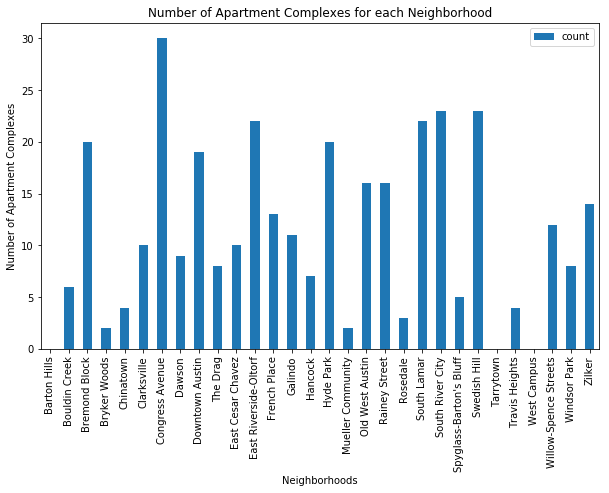

In [20]:
downtown_austin_df.plot(x="Neighborhoods", y="count", kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhoods') # add to x-label to the plot
plt.ylabel('Number of Apartment Complexes') # add y-label to the plot
plt.title('Number of Apartment Complexes for each Neighborhood') # add title to the plot

plt.show()

Now, let's use folium to map the neighborhood again but make the circle marker radius size reflex the count of apartment complexes in the area.

In [22]:
map_austin_apartment = folium.Map(location=[aus_lat, aus_long], zoom_start=13)

# add markers to map
for lat, lng, label, count in zip(downtown_austin_df['Latitude'], downtown_austin_df['Longitude'], downtown_austin_df['Neighborhoods'], downtown_austin_df['count']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=count,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin_apartment)  
    
map_austin_apartment

## Results and Discussion <a name="results"></a>

From my analysis, it is clear to see that neighborhood in the middle of downtown Austin that are near the river have the highest number of apartment complexes with Congress Avenue district having the highest. As I mentioned earlier, due to the close proximity of these neighborhoods, there may be some duplicates in the data and the counts for some districts will be higher. But the data gives a good indictation of where the apartment clusters seem to be centralized in Austin. 

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify which neighborhoods in Austin had the highest number of apartment complexes. It is my believe that this data could be used by some companies for marketing purposes. 

The next line of work would be to analyze which type of business venue would be best suited for these neighborhoods depending on this data. To do so, I would run the Foursquare API search again and find all venues in the given neighborhoods. With this information, I could perform regression analysis to see if there are correlations between the number of apartments in a neighborhood with a given business.

But I'm running out of data usage on Watson Studio for this month and wish to submit what I have completed.